<a href="https://colab.research.google.com/github/chandvariarajul/DMRC-Analysis/blob/main/Metro_Network_%26_Geospatial_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [98]:
import pandas as pd

In [99]:
agency = pd.read_csv('/content/drive/MyDrive/agency.txt', encoding='latin1')
calendar = pd.read_csv('/content/drive/MyDrive/calendar.txt', encoding='latin1')
routes = pd.read_csv('/content/drive/MyDrive/routes.txt', encoding='latin1')
shapes = pd.read_csv('/content/drive/MyDrive/shapes.txt', encoding='latin1')
stop_times = pd.read_csv('/content/drive/MyDrive/stop_times.txt', encoding='latin1')
stops = pd.read_csv('/content/drive/MyDrive/stops.txt', encoding='latin1')
trips = pd.read_csv('/content/drive/MyDrive/trips.txt', encoding='latin1')

In [100]:
data_snapshots = {
    "agency": agency.head(),
    "calendar": calendar.head(),
    "routes": routes.head(),
    "shapes": shapes.head(),
    "stop_times": stop_times.head(),
    "stops": stops.head(),
    "trips": trips.head()
}

In [101]:
data_snapshots

{'agency':   agency_id                   agency_name                      agency_url  \
 0      DMRC  Delhi Metro Rail Corporation  http://www.delhimetrorail.com/   
 
   agency_timezone  agency_lang  agency_phone  agency_fare_url  agency_email  
 0    Asia/Kolkata          NaN           NaN              NaN           NaN  ,
 'calendar':   service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
 0    weekday       1        1          1         1       1         0       0   
 1   saturday       0        0          0         0       0         1       0   
 2     sunday       0        0          0         0       0         0       1   
 
    start_date  end_date  
 0    20190101  20251231  
 1    20190101  20251231  
 2    20190101  20251231  ,
 'routes':    route_id  agency_id route_short_name  \
 0        33        NaN           R_SP_R   
 1        31        NaN           G_DD_R   
 2        29        NaN           P_MS_R   
 3        12        NaN             M_JB

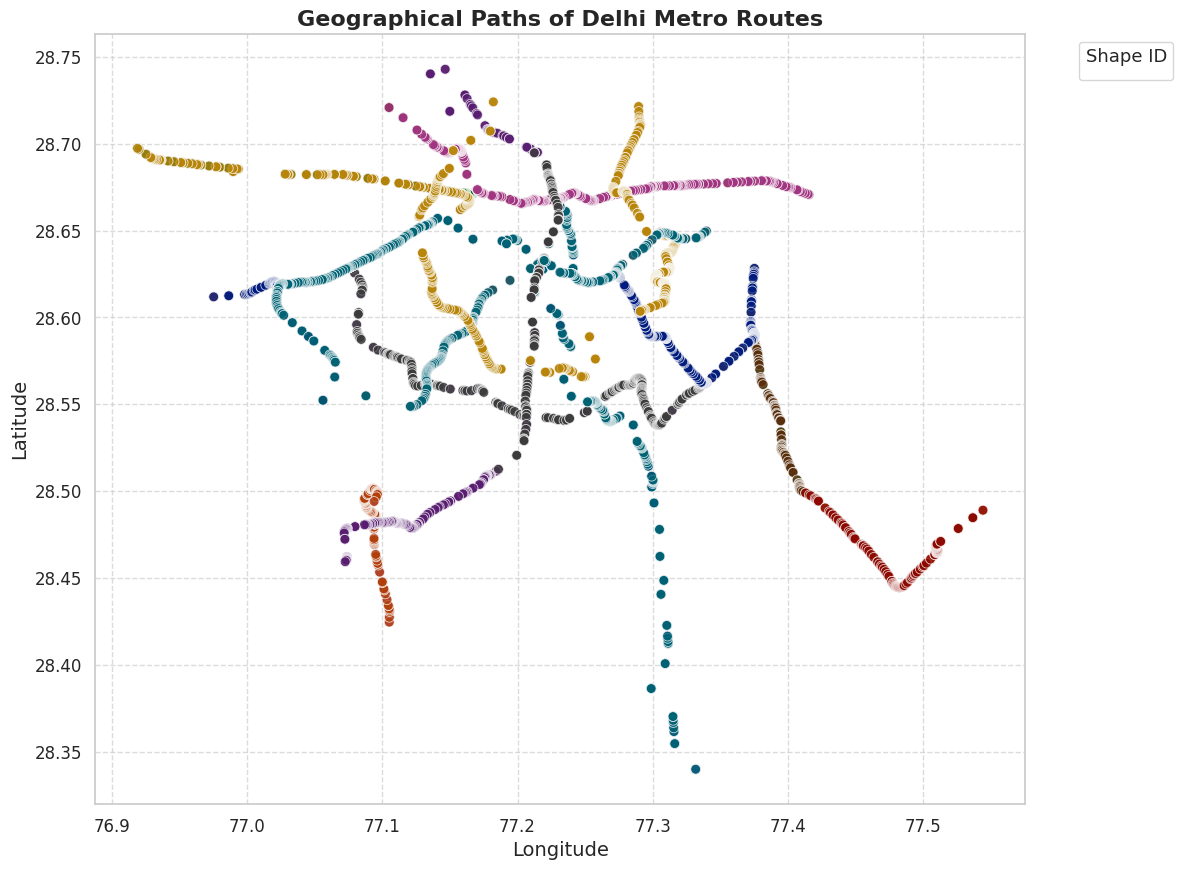

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style and context for better aesthetics
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))

# Convert 'shape_id' to a categorical type and create a color palette based on it
shapes['shape_id'] = shapes['shape_id'].astype('category')
palette = sns.color_palette('dark', n_colors=len(shapes['shape_id'].cat.categories))

# Create a scatter plot with enhanced features
scatter = sns.scatterplot(
    x='shape_pt_lon',
    y='shape_pt_lat',
    hue='shape_id',
    data=shapes,
    palette=palette,  # Color palette
    s=50,            # Size of the markers
    legend=None,
    alpha=0.8        # Transparency of markers
)

# Add a legend to provide context for the 'shape_id'
plt.legend(title='Shape ID', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize='13', fontsize='11')

# Add titles and labels
plt.title('Geographical Paths of Delhi Metro Routes', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Customize grid lines and ticks
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()


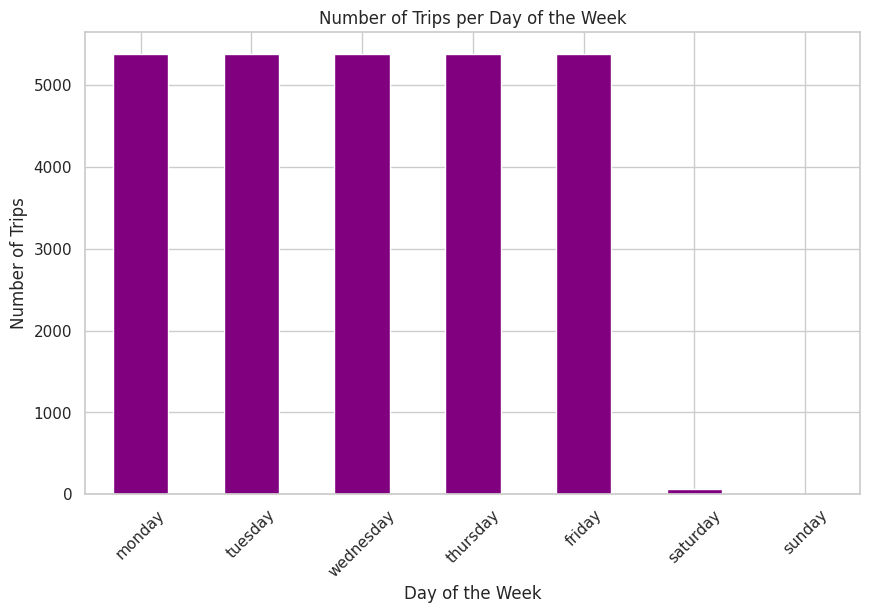

In [103]:
# merge trips with calendar to include the day of operation information
trips_calendar = pd.merge(trips, calendar, on='service_id', how='left')

# count the number of trips per day of the week
trip_counts = trips_calendar[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum()

# Plotting
plt.figure(figsize=(10, 6))
trip_counts.plot(kind='bar', color='purple')
plt.title('Number of Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

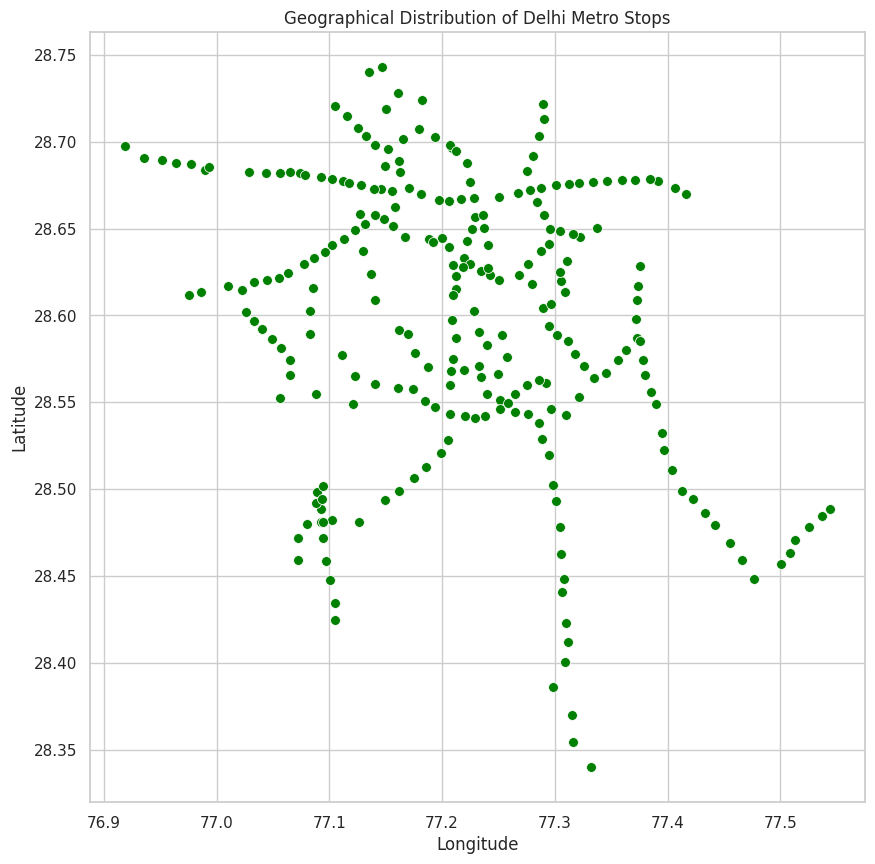

In [104]:
# plotting the locations of the stops
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', data=stops, color='green', s=50, marker='o')
plt.title('Geographical Distribution of Delhi Metro Stops')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

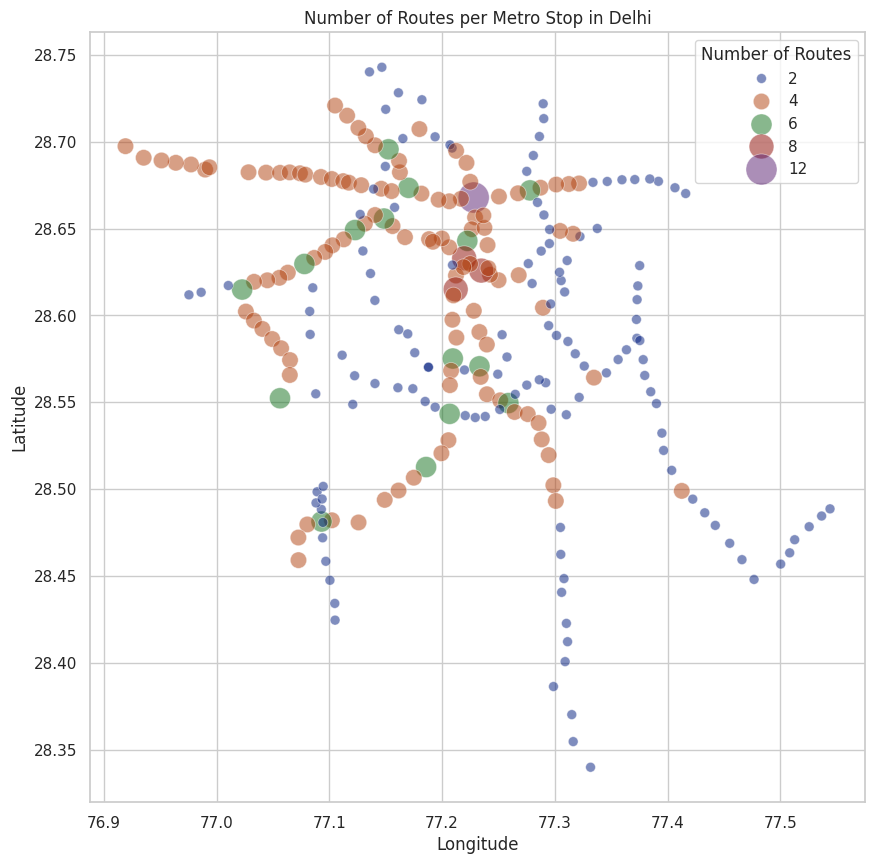

In [105]:
# merge stops with stop_times to link each stop with trips, and then merge with trips to get route information
stops_with_routes = pd.merge(pd.merge(stop_times, trips, on='trip_id'), routes, on='route_id')

# count how many unique routes pass through each stop
stop_route_counts = stops_with_routes.groupby('stop_id')['route_id'].nunique().reset_index()
stop_route_counts = stop_route_counts.rename(columns={'route_id': 'number_of_routes'})

# merge this with stops to get the names and location for plotting
stop_route_counts = pd.merge(stop_route_counts, stops, on='stop_id')

# plot the number of routes per stop
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', size='number_of_routes', hue='number_of_routes',
                sizes=(50, 500), alpha=0.5, palette='dark', data=stop_route_counts)
plt.title('Number of Routes per Metro Stop in Delhi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Number of Routes')
plt.grid(True)
plt.show()

<ipython-input-106-ac436aeb4486>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)
<ipython-input-106-ac436aeb4486>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='part_of_day', y='interval_minutes', data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette='mako')


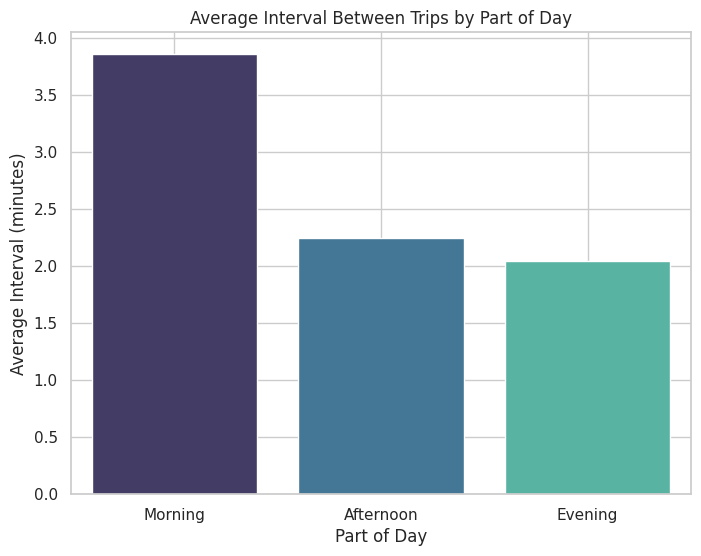

In [106]:
# converting stop_times 'arrival_time' from string to datetime.time for easier manipulation
import datetime as dt

# function to convert time string to datetime.time
def convert_to_time(time_str):
    try:
        return dt.datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:
        # Handle cases where the hour might be greater than 23 (e.g., 24:00:00 or 25:00:00)
        hour, minute, second = map(int, time_str.split(':'))
        return dt.time(hour % 24, minute, second)

stop_times['arrival_time_dt'] = stop_times['arrival_time'].apply(convert_to_time)

# calculate the difference in arrival times for subsequent trips at each stop
stop_times_sorted = stop_times.sort_values(by=['stop_id', 'arrival_time_dt'])
stop_times_sorted['next_arrival_time'] = stop_times_sorted.groupby('stop_id')['arrival_time_dt'].shift(-1)

# function to calculate the difference in minutes between two times
def time_difference(time1, time2):
    if pd.isna(time1) or pd.isna(time2):
        return None
    full_date_time1 = dt.datetime.combine(dt.date.today(), time1)
    full_date_time2 = dt.datetime.combine(dt.date.today(), time2)
    return (full_date_time2 - full_date_time1).seconds / 60

stop_times_sorted['interval_minutes'] = stop_times_sorted.apply(lambda row: time_difference(row['arrival_time_dt'], row['next_arrival_time']), axis=1)

# drop NaN values from intervals (last trip of the day)
stop_times_intervals = stop_times_sorted.dropna(subset=['interval_minutes'])

# average intervals by time of day (morning, afternoon, evening)
def part_of_day(time):
    if time < dt.time(12, 0):
        return 'Morning'
    elif time < dt.time(17, 0):
        return 'Afternoon'
    else:
        return 'Evening'

stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)
average_intervals = stop_times_intervals.groupby('part_of_day')['interval_minutes'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='part_of_day', y='interval_minutes', data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette='mako')
plt.title('Average Interval Between Trips by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Average Interval (minutes)')
plt.grid(True)
plt.show()

<ipython-input-107-51e86d57c243>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_interval', y='number_of_trips', data=trips_per_interval, palette='Set2')


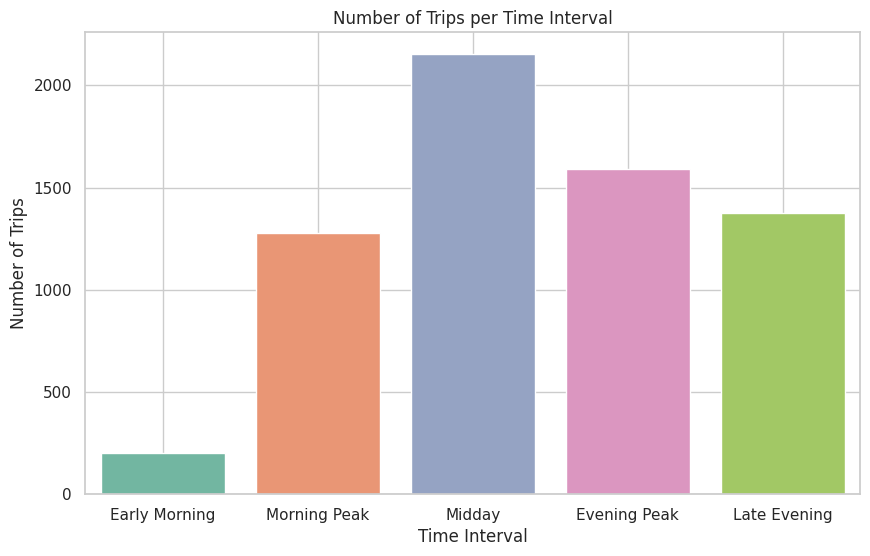

In [107]:
# define time intervals for classification
def classify_time_interval(time):
    if time < dt.time(6, 0):
        return 'Early Morning'
    elif time < dt.time(10, 0):
        return 'Morning Peak'
    elif time < dt.time(16, 0):
        return 'Midday'
    elif time < dt.time(20, 0):
        return 'Evening Peak'
    else:
        return 'Late Evening'

# apply time interval classification
stop_times['time_interval'] = stop_times['arrival_time_dt'].apply(classify_time_interval)

# count the number of trips per time interval
trips_per_interval = stop_times.groupby('time_interval')['trip_id'].nunique().reset_index()
trips_per_interval = trips_per_interval.rename(columns={'trip_id': 'number_of_trips'})

# sorting the dataframe
ordered_intervals = ['Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Late Evening']
trips_per_interval['time_interval'] = pd.Categorical(trips_per_interval['time_interval'], categories=ordered_intervals, ordered=True)
trips_per_interval = trips_per_interval.sort_values('time_interval')

# plotting the number of trips per time interval
plt.figure(figsize=(10, 6))
sns.barplot(x='time_interval', y='number_of_trips', data=trips_per_interval, palette='Set2')
plt.title('Number of Trips per Time Interval')
plt.xlabel('Time Interval')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

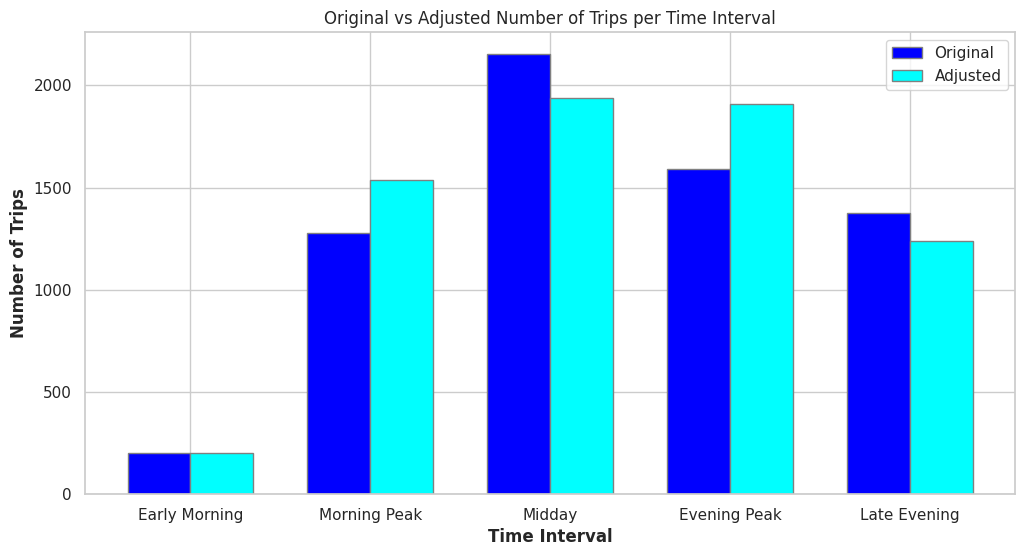

In [108]:
# adjusting frequencies based on hypothetical scenario
adjusted_trips_per_interval = trips_per_interval.copy()
adjustment_factors = {'Morning Peak': 1.20, 'Evening Peak': 1.20, 'Midday': 0.90, 'Early Morning': 1.0, 'Late Evening': 0.90}

# apply the adjustments
adjusted_trips_per_interval['adjusted_number_of_trips'] = adjusted_trips_per_interval.apply(
    lambda row: int(row['number_of_trips'] * adjustment_factors[row['time_interval']]), axis=1)

# plotting original vs adjusted number of trips per time interval
plt.figure(figsize=(12, 6))
bar_width = 0.35
r1 = range(len(adjusted_trips_per_interval))
r2 = [x + bar_width for x in r1]

plt.bar(r1, adjusted_trips_per_interval['number_of_trips'], color='blue', width=bar_width, edgecolor='grey', label='Original')
plt.bar(r2, adjusted_trips_per_interval['adjusted_number_of_trips'], color='cyan', width=bar_width, edgecolor='grey', label='Adjusted')

plt.xlabel('Time Interval', fontweight='bold')
plt.ylabel('Number of Trips', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(adjusted_trips_per_interval))], adjusted_trips_per_interval['time_interval'])
plt.title('Original vs Adjusted Number of Trips per Time Interval')
plt.legend()

plt.show()

In [111]:
import folium
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_white"

metro_data = pd.read_csv('/content/drive/MyDrive/Delhi-Metro-Network.csv' , encoding= 'latin1')

print(metro_data.head())

   Station ID         Station Name  Distance from Start (km)          Line  \
0           1             Jhil Mil                      10.3      Red line   
1           2  Welcome [Conn: Red]                      46.8     Pink line   
2           3          DLF Phase 3                      10.0   Rapid Metro   
3           4           Okhla NSIC                      23.8  Magenta line   
4           5           Dwarka Mor                      10.2     Blue line   

  Opening Date Station Layout   Latitude  Longitude  
0   2008-04-06       Elevated  28.675790  77.312390  
1   2018-10-31       Elevated  28.671800  77.277560  
2   2013-11-14       Elevated  28.493600  77.093500  
3   2017-12-25       Elevated  28.554483  77.264849  
4   2005-12-30       Elevated  28.619320  77.033260  


In [112]:
# checking for missing values
missing_values = metro_data.isnull().sum()

# checking data types
data_types = metro_data.dtypes

missing_values

,0
Station ID,0
Station Name,0
Distance from Start (km),0
Line,0
Opening Date,0
Station Layout,0
Latitude,0
Longitude,0


In [113]:
data_types

,0
Station ID,int64
Station Name,object
Distance from Start (km),float64
Line,object
Opening Date,object
Station Layout,object
Latitude,float64
Longitude,float64


In [114]:
# converting 'Opening Date' to datetime format
metro_data['Opening Date'] = pd.to_datetime(metro_data['Opening Date'])

In [119]:
# defining a color scheme for the metro lines
line_colors = {
    'Red line': 'red',
    'Blue line': 'blue',
    'Yellow line': 'yellow',
    'Green line': 'green',
    'Voilet line': 'purple',
    'Pink line': 'pink',
    'Magenta line': 'darkred',
    'Orange line': 'orange',
    'Rapid Metro': 'cadetblue',
    'Aqua line': 'black',
    'Green line branch': 'lightgreen',
    'Blue line branch': 'lightblue',
    'Gray line': 'lightgray'
}

delhi_map_with_line_tooltip = folium.Map(location=[28.7041, 77.1025], zoom_start=11)

# adding colored markers for each metro station with line name in tooltip
for index, row in metro_data.iterrows():
    line = row['Line']
    color = line_colors.get(line, 'black')  # Default color is black if line not found in the dictionary
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Station Name']}",
        tooltip=f"{row['Station Name']}, {line}",
        icon=folium.Icon(color=color)
    ).add_to(delhi_map_with_line_tooltip)

# Displaying the updated map
delhi_map_with_line_tooltip

<ipython-input-119-5032b847d44f>:28: UserWarning: color argument of Icon should be one of: {'beige', 'pink', 'darkred', 'lightred', 'black', 'green', 'orange', 'red', 'darkpurple', 'lightgreen', 'lightgray', 'darkgreen', 'darkblue', 'purple', 'cadetblue', 'blue', 'lightblue', 'gray', 'white'}.
  icon=folium.Icon(color=color)
